In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# pd.to_pickle((merged_df_j, merged_df), 'ff.pkl')
merged_df_j, merged_df = pd.read_pickle('ff.pkl')

<IPython.core.display.Javascript object>

In [2]:
from database.dataset import INBreast_Dataset
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from metrics.metrics import circle_comparison, quick_circle_comparison
from general_utils.plots import plot_bboxes_over_image, simple_im_show2, simple_im_show
from pathlib import Path
from tqdm import tqdm
import cv2


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
from general_utils.utils import get_tp_fp_fn_center_patch_criteria, patch_coordinates_from_center

In [4]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    partitions=['train', 'validation'],
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    use_muscle_mask=True
)

In [5]:

hd = HoughCalcificationDetection()


In [16]:
h1_res = []
h2_res = []

for idx in tqdm(range(len(db))):
    mask = db[idx]['lesion_mask']
    image = db[idx]['img']
    image_id = db.df.iloc[idx].img_id
    true_bboxes = db[idx]['lesion_bboxes']

    h1_circles, h2_circles = hd.detect(
        image, image_id, load_processed_images=True, hough2=True)

    
    TP, FP, FN = get_tp_fp_fn_center_patch_criteria(h1_circles, mask, None, 28, False)
    h1_res.append({'image_id':image_id, 'TP': len(TP), 'FP': len(FP), 'FN': len(FN)})
    
    TP, FP, FN = get_tp_fp_fn_center_patch_criteria(h2_circles, mask, None, 28, False)
    h2_res.append({'image_id': image_id, 'TP': len(TP), 'FP': len(FP), 'FN': len(FN)})

100%|██████████| 167/167 [14:06<00:00,  5.07s/it]


In [17]:
h1_res_df = pd.DataFrame(h1_res).set_index('image_id')
h1_res_df['sensitivity'] =  h1_res_df.TP/(h1_res_df.TP + h1_res_df.FN)
h1_res_df['f1'] =  h1_res_df.TP/(h1_res_df.TP + 0.5*(h1_res_df.FN + h1_res_df.FP))

h2_res_df = pd.DataFrame(h2_res).set_index('image_id')
h2_res_df['sensitivity'] =  h2_res_df.TP/(h2_res_df.TP + h2_res_df.FN)
h2_res_df['f1'] =  h2_res_df.TP/(h2_res_df.TP + 0.5*(h2_res_df.FN + h2_res_df.FP))

merged_df_j_3 = h1_res_df.join(h2_res_df, lsuffix='_h1', rsuffix='_h2')
merged_df_j_3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TP_h1,FP_h1,FN_h1,sensitivity_h1,f1_h1,TP_h2,FP_h2,FN_h2,sensitivity_h2,f1_h2
image_id,,,,,,,,,,
20586908,36,1465,9,0.800000,0.046572,57,152,18,0.760000,0.401408
20586934,54,1196,5,0.915254,0.082506,179,118,20,0.899497,0.721774
20586960,54,1625,3,0.947368,0.062212,174,153,12,0.935484,0.678363
20586986,17,1835,0,1.000000,0.018192,88,248,2,0.977778,0.413146
20587054,31,888,0,1.000000,0.065263,31,66,0,1.000000,0.484375
...,...,...,...,...,...,...,...,...,...,...
30011507,15,470,3,0.833333,0.059642,57,39,10,0.850746,0.699387
30011530,9,866,4,0.692308,0.020270,28,25,4,0.875000,0.658824
30011553,8,891,3,0.727273,0.017582,16,48,5,0.761905,0.376471


In [7]:
idx = 0

mask = db[idx]['lesion_mask']
image = db[idx]['img']
image_id = db.df.iloc[idx].img_id
true_bboxes = db[idx]['lesion_bboxes']

h1_circles, h2_circles = hd.detect(
    image, image_id, load_processed_images=True, hough2=True)

print(image_id)
print(merged_df.loc[image_id])

TP, FP, FN = quick_circle_comparison(h1_circles, mask, return_counts=True)
print({'image_id':image_id, 'TP': TP, 'FP': FP, 'FN': FN})

TP, FP, FN = quick_circle_comparison(h2_circles, mask)
print({'image_id': image_id, 'TP': TP, 'FP': FP, 'FN': FN})


print('total rois', len(set(mask.ravel())) -1)

print("J func")
btp, bfp, bfn = get_tp_fp_fn_center_patch_criteria(h1_circles, mask, None, 20, False)
print('hough1', {'TP':len(btp), 'FP':len(bfp), 'FN':len(bfn)})

btp, bfp, bfn = get_tp_fp_fn_center_patch_criteria(h2_circles, mask, None, 20, False)
print('hough2', {'TP':len(btp), 'FP':len(bfp), 'FN':len(bfn)})

20586908
TP_h1               30.000000
FP_h1             1461.000000
FN_h1               10.000000
sensitivity_h1       0.750000
f1_h1                0.039190
TP_h2               22.000000
FP_h2              152.000000
FN_h2               18.000000
sensitivity_h2       0.550000
f1_h2                0.205607
Name: 20586908, dtype: float64
{'image_id': 20586908, 'TP': 30, 'FP': 1461, 'FN': 10}
{'image_id': 20586908, 'TP': 22, 'FP': 152, 'FN': 18}
total rois 40
J func
hough1 {'TP': 28, 'FP': 1473, 'FN': 11}
hough2 {'TP': 22, 'FP': 153, 'FN': 18}


In [8]:
TP, FP, FN = quick_circle_comparison(h2_circles, mask, False)


In [9]:
btp, bfp, bfn = get_tp_fp_fn_center_patch_criteria(h2_circles, mask, None, 20, True)


In [14]:
[x for x in bfp if x not in h2_circles[list(FP)]]

[array([1109, 1597,   14])]

(1099, 1119, 1587, 1607)

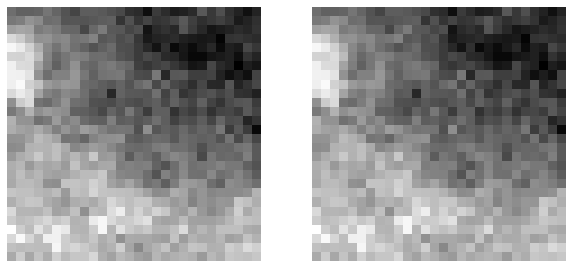

In [26]:
coords = (1109, 1597, 14)
cricle_tl = (max(0, coords[0] - coords[2]),
            max(0, coords[1] - coords[2]))
circle_br = (min(mask.shape[1], coords[0] + coords[2]),
            min(mask.shape[0], coords[1] + coords[2]))

patch_x1, patch_x2, patch_y1, patch_y2  = patch_coordinates_from_center(
                (coords[0], coords[1]), mask.shape, 28)

overlap_on_labels_J = image[patch_y1:patch_y2, patch_x1:patch_x2]
overlap_on_labels_me = image[cricle_tl[1]:circle_br[1], cricle_tl[0]:circle_br[0]]

simple_im_show2(overlap_on_labels_me, overlap_on_labels_J)

<AxesSubplot:>

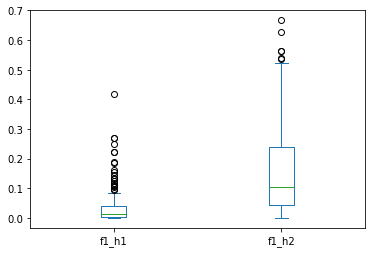

In [9]:
merged_df[['f1_h1', 'f1_h2']].plot.box()

<AxesSubplot:>

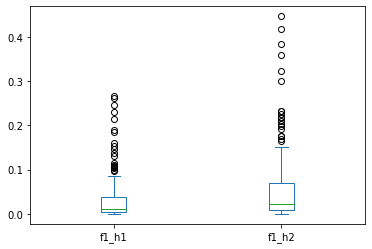

In [11]:
merged_df[['f1_h1', 'f1_h2']].plot.box()

<AxesSubplot:>

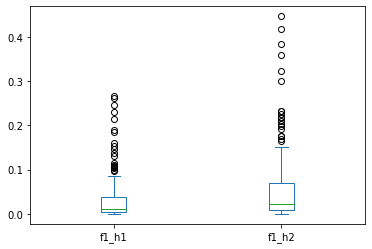

In [12]:
merged_df[['f1_h1', 'f1_h2']].plot.box()

<AxesSubplot:>

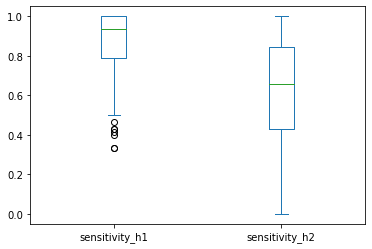

In [10]:
merged_df[['sensitivity_h1', 'sensitivity_h2']].plot.box()

<AxesSubplot:>

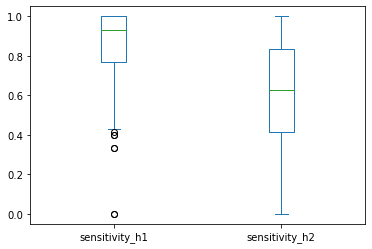

In [8]:
merged_df[['sensitivity_h1', 'sensitivity_h2']].plot.box()

<AxesSubplot:>

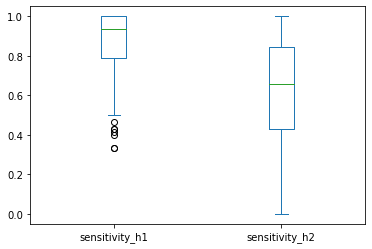

In [11]:
merged_df[['sensitivity_h1', 'sensitivity_h2']].plot.box()

<IPython.core.display.Javascript object>

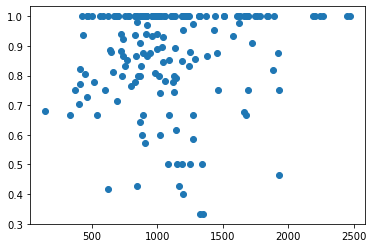

In [12]:
plt.scatter(h1_res_df.FP.values, h1_res_df.sensitivity.values)

In [11]:
h1_res_df.sensitivity.median()

0.9333333333333333

<AxesSubplot:ylabel='Frequency'>

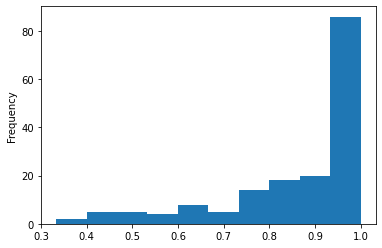

In [13]:
h1_res_df.sensitivity.plot.hist()

<AxesSubplot:ylabel='Frequency'>

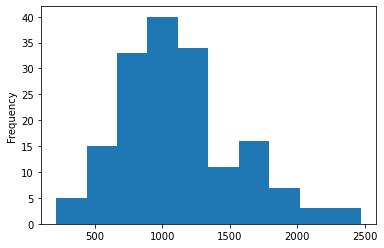

In [14]:
(h1_res_df.TP + h1_res_df.FP).plot.hist()

In [14]:
(h1_res_df.TP + h1_res_df.FP).mean()

1136.521212121212

In [55]:
merged_df_j

,TP_h1,FP_h1,FN_h1,sensitivity_h1,f1_h1,TP_h2,FP_h2,FN_h2,sensitivity_h2,f1_h2
image_id,,,,,,,,,,
20586908,28,1473,11,0.717949,0.036364,56,153,18,0.756757,0.395760
20586934,41,1209,18,0.694915,0.062643,178,119,22,0.890000,0.716298
20586960,36,1643,9,0.800000,0.041763,174,153,12,0.935484,0.678363
20586986,14,1838,0,1.000000,0.015005,86,250,2,0.977273,0.405660
20587054,30,889,0,1.000000,0.063224,31,66,0,1.000000,0.484375
...,...,...,...,...,...,...,...,...,...,...
30011507,12,473,8,0.600000,0.047525,57,39,12,0.826087,0.690909
30011530,7,868,6,0.538462,0.015766,28,25,5,0.848485,0.651163
30011553,7,892,4,0.636364,0.015385,16,48,6,0.727273,0.372093


<AxesSubplot:>

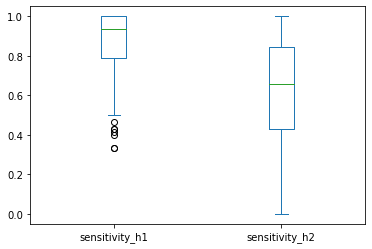

In [57]:
merged_df[['sensitivity_h1', 'sensitivity_h2']].plot.box()

<AxesSubplot:>

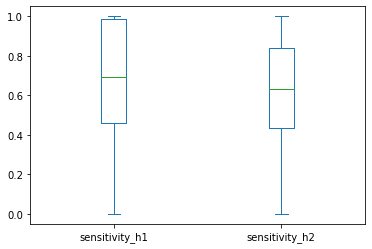

In [13]:
merged_df_j[['sensitivity_h1', 'sensitivity_h2']].plot.box()

<AxesSubplot:>

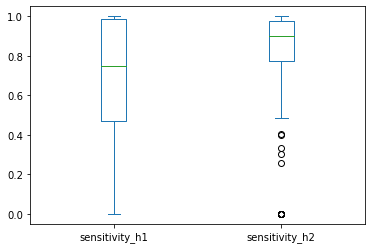

In [12]:
merged_df_j_2[['sensitivity_h1', 'sensitivity_h2']].plot.box()

<AxesSubplot:>

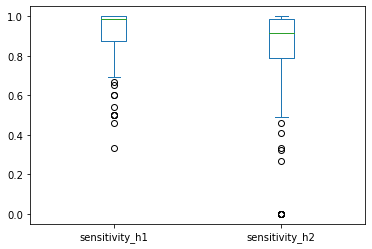

In [18]:
merged_df_j_3[['sensitivity_h1', 'sensitivity_h2']].plot.box()

In [67]:
print(merged_df.sensitivity_h1.mean(), merged_df.sensitivity_h1.median())
print(merged_df.sensitivity_h2.mean(), merged_df.sensitivity_h2.median())

0.8690618166717965 0.9354838709677419
0.623862939868704 0.6567164179104478


In [9]:
print(merged_df_j.sensitivity_h1.mean(), merged_df_j.sensitivity_h1.median())
print(merged_df_j.sensitivity_h2.mean(), merged_df_j.sensitivity_h2.median())

0.6723367019435252 0.6923076923076923
0.624534655687683 0.6333333333333333


In [69]:
merged_df_j[merged_df.sensitivity_h2 < merged_df_j.sensitivity_h2]

,TP_h1,FP_h1,FN_h1,sensitivity_h1,f1_h1,TP_h2,FP_h2,FN_h2,sensitivity_h2,f1_h2
image_id,,,,,,,,,,
20586908,28,1473,11,0.717949,0.036364,56,153,18,0.756757,0.395760
20586934,41,1209,18,0.694915,0.062643,178,119,22,0.890000,0.716298
20586960,36,1643,9,0.800000,0.041763,174,153,12,0.935484,0.678363
20586986,14,1838,0,1.000000,0.015005,86,250,2,0.977273,0.405660
20587174,13,468,0,1.000000,0.052632,59,29,5,0.921875,0.776316
...,...,...,...,...,...,...,...,...,...,...
30011484,5,628,7,0.416667,0.015504,26,25,7,0.787879,0.619048
30011507,12,473,8,0.600000,0.047525,57,39,12,0.826087,0.690909
30011530,7,868,6,0.538462,0.015766,28,25,5,0.848485,0.651163


In [80]:
set([0, 1, 2, 3]).difference(set([0]))

{1, 2, 3}

In [85]:
set([0, 1, 4]).difference(set([0, 1, 2, 3]))

{4}